In [52]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
from mendeleev import element

In [8]:
coords=[]
elements=[]
for lineidx,line in enumerate(open("data/coordinates_TS/ir_tbp_1_dft-asme3_1_dft-asme3_1_dft-co_1_dft-icn_1_smi1_1_s_1_ts.xyz","r")):
    if lineidx >= 2:
        elements.append(line.split()[0].capitalize())
        coords.append([float(line.split()[1]),float(line.split()[2]),float(line.split()[3])])
coords=np.array(coords)

In [9]:
print(coords)
print(elements)

[[-0.092476 -0.27605  -0.232554]
 [-0.120361 -0.578618 -1.929409]
 [-0.057964  0.36163  -1.983606]
 [ 2.3435   -0.25933  -0.092274]
 [ 3.034775  0.340348  1.63516 ]
 [ 3.244248  0.965707 -1.322539]
 [ 3.262767 -1.963248 -0.375416]
 [ 2.767462  1.407538  1.760456]
 [ 4.135848  0.22427   1.667487]
 [ 2.561803 -0.25739   2.436279]
 [ 2.960168  1.99865  -1.041589]
 [ 2.910162  0.756869 -2.35616 ]
 [ 4.342649  0.846848 -1.244835]
 [ 2.867622 -2.698561  0.351482]
 [ 4.356232 -1.847813 -0.243339]
 [ 3.040024 -2.322309 -1.398132]
 [-2.487998  0.111539 -0.034788]
 [-3.735596 -1.37684  -0.270334]
 [-3.14416   1.488792 -1.252094]
 [-2.946812  0.829995  1.719353]
 [-3.633274 -1.770611 -1.299428]
 [-4.778765 -1.049998 -0.093112]
 [-3.463763 -2.177471  0.444117]
 [-3.051848  1.12571  -2.29326 ]
 [-2.483672  2.365645 -1.110832]
 [-4.196922  1.750306 -1.029876]
 [-2.745766  0.055402  2.483184]
 [-4.007467  1.145726  1.759618]
 [-2.270506  1.689793  1.886898]
 [-0.179204 -1.872994  0.697773]
 [-0.22640

In [32]:
#Center
metal = coords[0]
coords = coords - metal

print(coords)

[[ 0.        0.        0.      ]
 [-0.027885 -0.302568 -1.696855]
 [ 0.034512  0.63768  -1.751052]
 [ 2.435976  0.01672   0.14028 ]
 [ 3.127251  0.616398  1.867714]
 [ 3.336724  1.241757 -1.089985]
 [ 3.355243 -1.687198 -0.142862]
 [ 2.859938  1.683588  1.99301 ]
 [ 4.228324  0.50032   1.900041]
 [ 2.654279  0.01866   2.668833]
 [ 3.052644  2.2747   -0.809035]
 [ 3.002638  1.032919 -2.123606]
 [ 4.435125  1.122898 -1.012281]
 [ 2.960098 -2.422511  0.584036]
 [ 4.448708 -1.571763 -0.010785]
 [ 3.1325   -2.046259 -1.165578]
 [-2.395522  0.387589  0.197766]
 [-3.64312  -1.10079  -0.03778 ]
 [-3.051684  1.764842 -1.01954 ]
 [-2.854336  1.106045  1.951907]
 [-3.540798 -1.494561 -1.066874]
 [-4.686289 -0.773948  0.139442]
 [-3.371287 -1.901421  0.676671]
 [-2.959372  1.40176  -2.060706]
 [-2.391196  2.641695 -0.878278]
 [-4.104446  2.026356 -0.797322]
 [-2.65329   0.331452  2.715738]
 [-3.914991  1.421776  1.992172]
 [-2.17803   1.965843  2.119452]
 [-0.086728 -1.596944  0.930327]
 [-0.13393

In [ ]:
#Rotate

#---TODO---

In [6]:
def drawSphere(xCenter, yCenter, zCenter, r):
       #draw sphere
       u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
       x=np.cos(u)*np.sin(v)
       y=np.sin(u)*np.sin(v)
       z=np.cos(v)
       # shift and scale sphere
       x = r*x + xCenter
       y = r*y + yCenter
       z = r*z + zCenter
       return (x,y,z)

Element: Ir, r: 233.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: As, r: 231.0
Element: C, r: 190.0
Element: C, r: 190.0
Element: C, r: 190.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: As, r: 231.0
Element: C, r: 190.0
Element: C, r: 190.0
Element: C, r: 190.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: H, r: 154.0
Element: C, r: 190.0
Element: O, r: 171.0
Element: N, r: 179.0
Element: C, r: 190.0
Element: O, r: 171.0


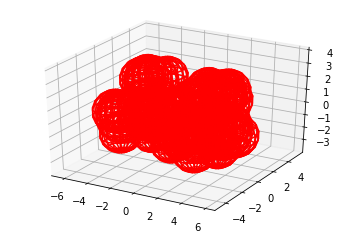

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
axes = plt.gca()
#axes.set_xlim([-2,2])
#axes.set_ylim([-2,2])
#axes.set_zlim([-2,2])
for ((x,y,z), elem) in zip(coords, elements):
    #print((x,y,z))
    r = element(elem).atomic_radius_rahm
    print("Element: " + elem + ", r: " + str(r))
    (xs,ys,zs) = drawSphere(x,y,z,r/100) #/100 for Angström to Picometre conversion
    #print((xs,ys,zs))
    ax.plot_wireframe(xs,ys,zs, color="r")
    
plt.show()